## Import Required Python Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
%matplotlib inline
os.chdir('Data set')

## Pose Data Analysis Question

Of Major League Baseball batting statistics, what is the greatest indicator of a player's value, as evidenced by his average salary over his career? The most popular batting statistics used today are batting average, on-base percentage, and slugging percentage. I also added a fourth statistic to measure, home runs per at bat, because I wanted to see if the splashiness of hitting home runs by itself correlated to higher player salaries.

To answer this question, I first read in the 'Batting' and 'Salaries' files from Sean Lahman's online database of baseball statistics. Then I calculated the four chosen batting statistics for each season for each player in the database. Then I normalized both he batting and salary data in terms of standard deviations from the mean for the given year, and merged that data together in a single Pandas DataFrame. Then I grouped the data by player ID, and averaged their statistics over their career. The final step was to plot the correlation of each statistic (independent variable) to the player's salary (dependent variable), and calculate Pearson's coefficient for each to determine which statistic was the strongest indicator of player value, as evidenced by his average career salary. Other variable relationships are also examined, such as the relationship of the number of at bats per season to the correlation between the various batting statistics and player salaries. These steps are demonstrated in detail below.

## Step 1: Read in data from CSV

In [2]:
# we'll just use Pandas' built-in read_csv function for reading the CSV's for batting and salaries data into Pandas Dataframes
batting_data = pd.read_csv('Batting.csv')
salaries_data = pd.read_csv('Salaries.csv')

# made a simple method for previewing DataFrame data, since I do this many times throughout the project
def preview_df(df, name):
    print("{0} preview:".format(name))
    print(df[:3])

preview_df(batting_data, "Batting data")
preview_df(salaries_data, "Salaries data")

Batting data preview:
    playerID  yearID  stint teamID lgID   G     AB     R     H   2B  ...   \
0  abercda01    1871      1    TRO  NaN   1    4.0   0.0   0.0  0.0  ...    
1   addybo01    1871      1    RC1  NaN  25  118.0  30.0  32.0  6.0  ...    
2  allisar01    1871      1    CL1  NaN  29  137.0  28.0  40.0  4.0  ...    

    RBI   SB   CS   BB   SO  IBB  HBP  SH  SF  GIDP  
0   0.0  0.0  0.0  0.0  0.0  NaN  NaN NaN NaN   NaN  
1  13.0  8.0  1.0  4.0  0.0  NaN  NaN NaN NaN   NaN  
2  19.0  3.0  1.0  2.0  5.0  NaN  NaN NaN NaN   NaN  

[3 rows x 22 columns]
Salaries data preview:
   yearID teamID lgID   playerID  salary
0    1985    ATL   NL  barkele01  870000
1    1985    ATL   NL  bedrost01  550000
2    1985    ATL   NL  benedbr01  545000


## Step 2: Clean Up Data
I'll go into greater detail in the next step about how the various batting statistics will be calculated, but before we get to that we need to make sure each record of data we work with has everything we need. The data we need to calculate the statistics are the following:  H (hits), AB (at bats), 2B (doubles), 3B (triples), HR (home runs), BB (walks), HBP (hit by pitch), SF (sacrifice flies), and R (runs scored). Additionally, we of course need the playerID and yearID, which we'll use to link the batting data to the salaries data.

#### Identify and Remove Rows with NaN Values for Critical Statistics
First we'll identify which of our required values are missing, then remove those values from the results. Another option would be to zero them out, but I think that would be misleading, since not having the statistic 'HBP' (hit by pitch) for a given player in a given year is not the same as saying that player was never hit by a pitch that year.

In [3]:
# identify which fields have missing values, and how many values are missing
batting_data.isnull().sum()

playerID        0
yearID          0
stint           0
teamID          0
lgID          737
G               0
AB           5149
R            5149
H            5149
2B           5149
3B           5149
HR           5149
RBI          5573
SB           6449
CS          28603
BB           5149
SO          12987
IBB         41712
HBP          7959
SH          11487
SF          41181
GIDP        31257
dtype: int64

There we can see that playerID and yearID values are present in every record, as you would expect. Our other required values are missing in at least some records. It's interesting to note that AB, R, H, 2B, 3B, HR, and BB are all missing in exactly 5,149 rows, while the other required values (SF, HBP) are missing in different (and far greater) amounts. My guess is we have some records, possibly early ones, with no batting data available whatsoever. First we'll remove all records that are missing any of these values.

In [4]:
# now we'll run a query to remove all the data where each required value is not filled
# first identify required columns (we had to remove 2B and 3B since they start with numbers and throw an error)
required_columns = ['playerID', 'yearID', 'H', 'BB', 'HBP', 'AB', 'SF', 'HR']
# then turn those columns into required syntax for a df.query
required_query = " & ".join(["{0} == {0}".format(i) for i in required_columns])
# run the query, and also filter out all the columns we don't need (with 2B and 3B added back in)
removed_nans = batting_data.query(required_query).ix[:, (required_columns + ['2B', '3B'])]

preview_df(removed_nans, "Data with NaN values removed")

Data with NaN values removed preview:
       playerID  yearID    H   BB  HBP   AB   SF   HR   2B   3B
4560  colemjo02    1890  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
5088  brynato01    1891  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
5177  dunnian01    1891  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0


#### Enforce Cut-off Value for At Bats
Now we can see from the preview above that even with all the NaN values removed, there is a certain number of records with 0.0 as the value for all batting statistics. For every statistic except AB, it is possible that the value could legitimately be 0.0, so we don't want to remove everything. We'll just remove those with 0.0 for AB. While we're at it, we should probably define a cut-off for at bats, as short seasons could skew our data (for example, a player with only one at bat but who hit a home run in that bat would have off the charts statistics, but you wouldn't expect that player to keep up that pace over an entire season). Per [MLB rules and regulations](http://mlb.mlb.com/mlb/official_info/about_mlb/rules_regulations.jsp), the minimum number of at bats in a season to be considered a full season for determining rookie status is 130. So we'll use that for the cut-off.

In [5]:
filtered_bd = pd.DataFrame(removed_nans.query("AB > 130"))
preview_df(filtered_bd, "At bats greater than 130")

At bats greater than 130 preview:
        playerID  yearID      H    BB  HBP     AB   SF    HR    2B   3B
36871  aaronha01    1954  131.0  28.0  3.0  468.0  4.0  13.0  27.0  6.0
36874  abramca01    1954  124.0  72.0  4.0  423.0  1.0   6.0  22.0  7.0
36875  adamsbo03    1954  105.0  55.0  3.0  390.0  2.0   3.0  25.0  6.0


#### Remove batting data where there's no corresponding salaries data
We also need to make sure we can match our batting data to the salaries data. Below we can see that there are no NaN values in the salaries data for yearID and playerID, so we can use those to match to the batting data. But we also see that the first year in the salaries data is 1985.

In [6]:
salaries_data.isnull().sum()

yearID      0
teamID      0
lgID        0
playerID    0
salary      0
dtype: int64

In [7]:
salaries_data['yearID'].min()

1985

So we'll add that filter as well, and then preview to make sure we have no more missing data

In [8]:
# filter out all records where the yearID is less than 1985
filtered_bd = filtered_bd.query('yearID >= 1985')
# look for NaN values
filtered_bd.isnull().sum()

playerID    0
yearID      0
H           0
BB          0
HBP         0
AB          0
SF          0
HR          0
2B          0
3B          0
dtype: int64

In [9]:
preview_df(filtered_bd, "Filtered batting data")

Filtered batting data preview:
        playerID  yearID     H    BB  HBP     AB   SF   HR    2B   3B
62242  aguaylu01    1985  46.0  22.0  6.0  165.0  3.0  6.0   7.0  3.0
62249  almonbi01    1985  66.0  22.0  1.0  244.0  3.0  6.0  17.0  0.0
62250  anderda02    1985  44.0  35.0  1.0  221.0  1.0  4.0   6.0  0.0


## Step 3: Calculate Batting Statistics

The formulas for the four batting statistics are as follows:

##### Batting average (BA)

$
\begin{align}
h \div ab
\end{align}
$

##### On-base percentage (OBP)

$
\begin{align}
(h + bb + hbp) \div (ab + bb + hbp + sf)
\end{align}
$

##### Home runs per at bat (HRAB)

$
\begin{align}
hr \div ab
\end{align}
$


##### Slugging percentage (SLG)

$
\begin{align}
tb \div ab
\end{align}
$

##### Key

* h = hits
* bb = walks ('bases on balls')
* hbp = hit by pitch
* ab = at bats
* sf = sacrifice flies
* hr = home runs
* r = runs scored
* tb = total bases

#### Calculate Batting Average (BA), On-base Percentage (OBP), Home Runs per At Bat (HRAB), and Slugging Percentage (SLG)
Here we add new columns to the DataFrame for all our chosen statistics, as well as helper statistics needed to calculate the chosen statistics. Once these are done, we can remove all the columns we no longer need.

In [10]:
# BATTING AVERAGE
# use NumPy 'divide' function to add new column to our dataframe, which is the result of dividing hits from at bats,
# and rounding to 3 decimal places, as is standard practice in baseball
filtered_bd['BA'] = np.divide(filtered_bd['H'], filtered_bd['AB']).round(3)

# ON-BASE PERCENTAGE
# first calculate times on base (TOB)
filtered_bd['TOB'] = filtered_bd['H'] + filtered_bd['BB'] + filtered_bd['HBP']
# next calculate plate appearances (PA)
filtered_bd['PA'] = filtered_bd['AB'] + filtered_bd['BB'] + filtered_bd['HBP'] + filtered_bd['SF']
# then divide TOP by PA to get on-based percentage(OBP)
filtered_bd['OBP'] = np.divide(filtered_bd['TOB'], filtered_bd['PA']).round(3)

# HOME RUNS PER AT BAT
# divide home runs from at bats to calculate home runs per at bat
filtered_bd['HRAB'] = np.divide(filtered_bd['HR'], filtered_bd['AB']).round(3)

# SLUGGING PERCENTAGE
# for slugging percentage, first calculate total bases (4 bases for home run, 3 for triple, and so on)
filtered_bd['TB'] = (filtered_bd['HR'] * 4) + (filtered_bd['3B'] * 3) + (filtered_bd['2B'] * 2) + (filtered_bd['H'] - (filtered_bd['2B'] + filtered_bd['3B'] + filtered_bd['HR']))
# then divide total bases from at bats
filtered_bd['SLG'] = np.divide(filtered_bd['TB'], filtered_bd['AB']).round(3)

# remove no longer needed columns
needed_columns = ['playerID', 'yearID', 'AB', 'BA', 'OBP', 'HRAB', 'SLG']
calculated_bd = filtered_bd.ix[:, needed_columns]

preview_df(calculated_bd, 'Calculated batting data')

Calculated batting data preview:
        playerID  yearID     AB     BA    OBP   HRAB    SLG
62242  aguaylu01    1985  165.0  0.279  0.378  0.036  0.467
62249  almonbi01    1985  244.0  0.270  0.330  0.025  0.414
62250  anderda02    1985  221.0  0.199  0.310  0.018  0.281


#### Convert Statistics to Standard Deviations from Mean
In order to better compare batting statistics from different eras, we'll normalize each statistic by converting it into how many standard deviations it is away from the mean for that statistic for that year.

In [11]:
# this method takes a dataframe, a key for determining which value in the data to calculate on
# and which columns to perform the calculations on
# then it will return an updated dataframe with all the specified columns normalized in terms of
# standard deviations from the mean
def normalize_dataframe(input_df, key, columns):
    # creates a copy of the input dataframe, to house the normalized data we'll output
    output_df = input_df.copy()
    # iterate through the given key--in this case, 'yearID'--so we can calculate mean and std for that key
    for i in range(input_df[key].min(), input_df[key].max() + 1):
        # grab the subset of the data for that year, and keep only the columns specified, which we want to calculate
        subset_df = input_df.query("{0} == {1}".format(key, i)).ix[:, columns]
        # normalize the data by subtracting each value from the mean then dividing by the standard deviation
        # also round the data to 3 decimal places so we don't have scientific notation in the output
        subset_df_norm = round(((subset_df - subset_df.mean()) / subset_df.std()),3)
        # update the output dataframe with the normalized data
        output_df.update(subset_df_norm)
    return output_df

normalized_bd = normalize_dataframe(calculated_bd, 'yearID', ['AB', 'BA', 'OBP', 'HRAB', 'SLG'])
preview_df(normalized_bd, 'Normalized batting data')

Normalized batting data preview:
        playerID  yearID     AB     BA    OBP   HRAB    SLG
62242  aguaylu01    1985 -1.353  0.658  1.417  0.608  1.056
62249  almonbi01    1985 -0.855  0.370  0.114 -0.018  0.297
62250  anderda02    1985 -1.000 -1.907 -0.428 -0.416 -1.608


## Step 4: Merge Batting Statistics with Salary Data

Just as we did with our batting statistics, we'll calculate mean salary for each year, as well as standard deviation, then measure each player's salary in terms of standard deviations from the mean. This will allow us to normalize for inflation when dealing with player salaries. Then we'll merge the normalized salaries data with the normalized batting data to create a new 'joined_data' dataframe.

In [12]:
# we can use our normalize_dataframe method from earlier to normalize all the salaries in the salaries_data dataframe
normalized_salaries = normalize_dataframe(salaries_data, 'yearID', ['salary'])

# this merges the two normalized dataframes together, while removing the columns from the salaries df that we don't care about
joined_data = normalized_bd.merge(normalized_salaries.ix[:, ['playerID', 'yearID', 'salary']],
                                  how='inner',
                                  on=['yearID', 'playerID']
                                 )
preview_df(joined_data, 'Joined and normalized data')

Joined and normalized data preview:
    playerID  yearID     AB     BA    OBP   HRAB    SLG  salary
0  aguaylu01    1985 -1.353  0.658  1.417  0.608  1.056  -0.697
1  almonbi01    1985 -0.855  0.370  0.114 -0.018  0.297  -0.645
2  armasto01    1985  0.035  0.209 -0.754  1.973  1.729   1.278


## Step 5: Explore Data
Before proceeding further, let's take a look at the data we have and see if we can find any issues with the data. Here we'll look at how much data there is per year, to see if the data might be skewed toward the more recent past.

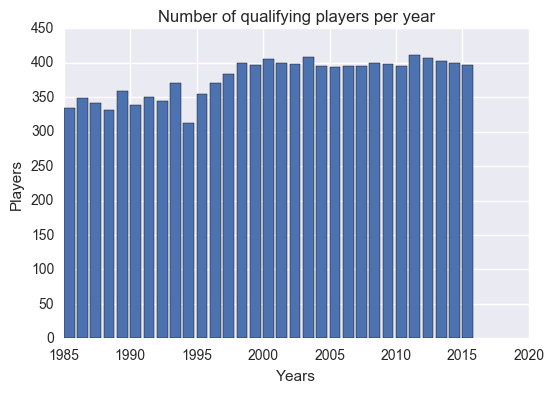

In [96]:
player_counts_by_year = normalized_bd.groupby(by='yearID')['playerID'].count()

player_counts = player_counts_by_year.values
years = player_counts_by_year.index
mean = player_counts_by_year.mean()
std = player_counts_by_year.std()
minimum = player_counts_by_year.min()

plt.bar(years, player_counts)
plt.title ("Number of qualifying players per year")
plt.xlabel("Years")
plt.ylabel("Players")
plt.show()

At first glance, it appears that the number of players per season is a bit lower on average between 1985 and 1997 than it is from 1998 to 2015. Another interesting item is that there's one year--1994--that has a significantly lower number of qualifying players than all the others. This just happens to be the [strike-shortened year of 1994](https://www.google.com/url?sa=t&rct=j&q=&esrc=s&source=web&cd=3&cad=rja&uact=8&ved=0ahUKEwiD2s-uwrvSAhXowlQKHXIrAoAQFggiMAI&url=https%3A%2F%2Fen.wikipedia.org%2Fwiki%2F1994%25E2%2580%259395_Major_League_Baseball_strike&usg=AFQjCNHYJD6ah2_oVmTdaAPhywBA66osnQ&sig2=3caMrG-KuRsZAMV3sxRafw&bvm=bv.148747831,d.cGw), which would explain why there were so many fewer players with enough at bats to qualify for our analysis. However, since we normalized the data so that each player's statistics for each year are in terms of their standard deviations from the mean for that year, I don't know that having more data from more recent years will necessarily skew the data, or even that the strike-shortened season would skew the data. But we'll consider that when we plot our correlations and see if there is indeed a statistical difference.

## Step 6: Average Player Batting Statistics and Salaries for All Years Played
In order to better correlate statistics to salaries, we'll average all the statistics and salaries for each player over their entire career. This helps correct the problem we could have with rookies or young player having a great season on a rookie contract, so the performance would not correlate well with the salary. For this, we'll look at three groups of data:  one for all years included, one without the strike-shortened 1994 season, and one with only data after 1997.

In [132]:
# group on playerID, calculate mean for all columns except yearID (just count those, so we know how many years the player played)
# then rename the 'yearID' column to 'numYears', to better reflect what it represents
def group_df(df, years_filter=''):
    if years_filter != '':
        df = df.query(years_filter)
    average_data = df.groupby(by='playerID').agg({
            'yearID' : np.size,
            'AB' : np.mean,
            'BA' : np.mean,
            'OBP' : np.mean,
            'HRAB' : np.mean,
            'SLG' : np.mean,
            'salary' : np.mean
        }).rename(columns={'yearID' : 'numYears'}).round(3)
    return average_data

average_data_all = group_df(joined_data)
average_data_sans_1994 = group_df(joined_data, 'yearID != 1994')
average_data_post_1997 = group_df(joined_data, 'yearID > 1997')
preview_df(average_data_all, "Averaged data including all seasons")
preview_df(average_data_sans_1994, "Averaged data without 1994 season")
preview_df(average_data_post_1997, "Averaged data after 1997 season")

Averaged data including all seasons preview:
             OBP  numYears   HRAB     BA  salary     AB    SLG
playerID                                                      
abbotje01 -0.484         2  0.036  0.206  -0.648 -0.854  0.194
abbotku01 -0.914         6 -0.037 -0.521  -0.493 -0.303 -0.074
abercre01 -1.746         1 -0.639 -1.887  -0.664 -0.763 -1.393
Averaged data without 1994 season preview:
             OBP  numYears   HRAB     BA  salary     AB    SLG
playerID                                                      
abbotje01 -0.484         2  0.036  0.206  -0.648 -0.854  0.194
abbotku01 -0.848         5 -0.002 -0.471  -0.453 -0.452 -0.000
abercre01 -1.746         1 -0.639 -1.887  -0.664 -0.763 -1.393
Averaged data after 1997 season preview:
             OBP  numYears   HRAB     BA  salary     AB    SLG
playerID                                                      
abbotje01 -0.484         2  0.036  0.206  -0.648 -0.854  0.194
abbotku01 -1.180         2 -0.008 -0.792  -0.439 -0.

## Step 7: Plot Correlations Between Player Batting Statistics and Salaries
Here we'll use matplotlib to plot the correlations between our four chosen batting statistics and player salaries, both in terms of standard deviations from the mean. We'll also use the Pandas df.corr function to calculate the Pearson's coefficient or Pearson's r value, which measures the correlation between the specified statistic and player salary. The method below also allows us to filter on number of years played in the league, to remove short careers that might negatively skew the results. For the examples below, we only looked at players whose careers lasted at least 5 years in the league.

In [135]:
def plot_data(dataframe, stat, stat_name, years, dataset):
    # determine minimum number of years for a player's career (removes short careers which could skew the data)
    df = dataframe.query('numYears >= {0}'.format(years))
    # grab Pearson's coefficient score, to determine the correlation between the specified statistic and player salary
    pearsons_r = round(df.corr(method='pearson')[stat]['salary'], 3)
    # grab the average salary for each value for the specified statistic
    # for example, for every time we have a StD score of 1.5 for Slugging Percentage, what's the corresponding average salary?
    plotting_data = df.groupby(by=stat).mean().ix[:,['salary']]
    plt.plot(plotting_data, linewidth='1')
    plt.text(-1, 4, r"Pearson's r: {0}".format(pearsons_r),
            bbox={'facecolor':'red', 'alpha':0.5, 'pad':10})
    plt.xlabel(stat_name + " (SDs from Mean)")
    plt.ylabel('Player Salary (SDs from Mean)')
    plt.title("Correlation of {0} to Player Salary ({1})".format(stat_name, dataset))
    plt.show()

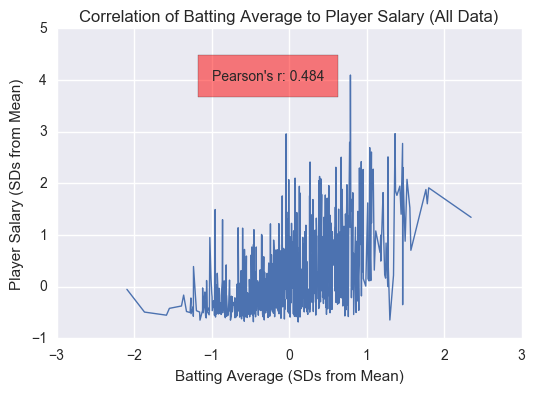

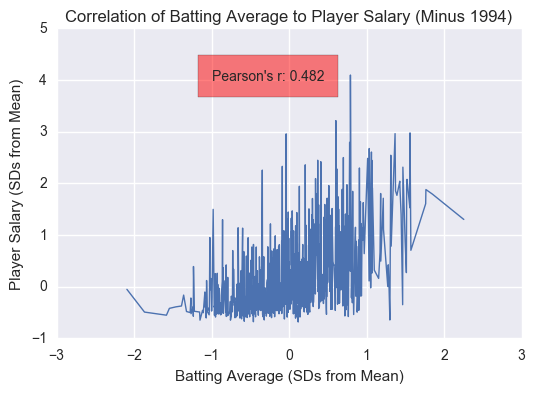

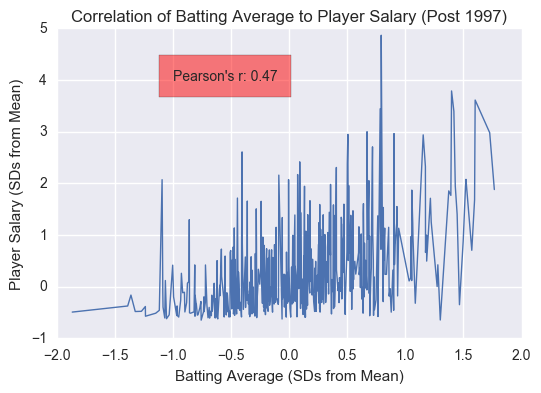

In [136]:
plot_data(average_data_all, 'BA', 'Batting Average', 5, 'All Data')
plot_data(average_data_sans_1994, 'BA', 'Batting Average', 5, 'Minus 1994')
plot_data(average_data_post_1997, 'BA', 'Batting Average', 5, 'Post 1997')

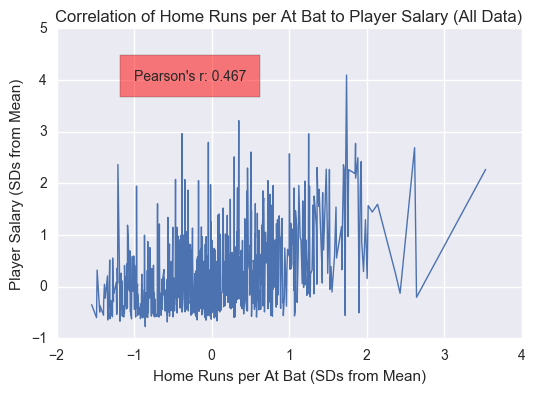

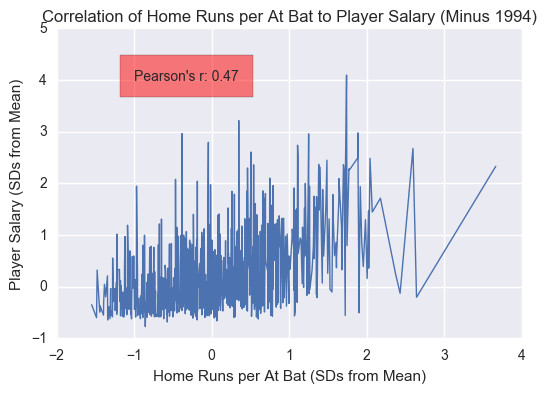

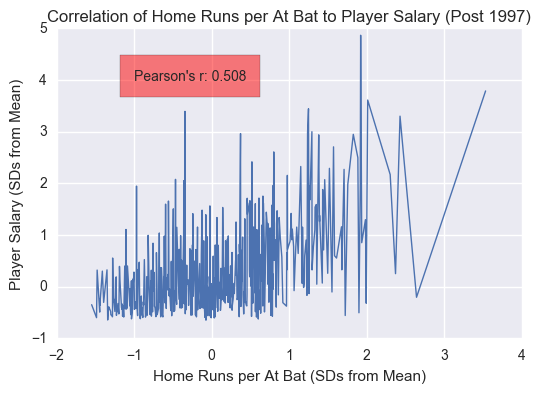

In [137]:
plot_data(average_data_all, 'HRAB', 'Home Runs per At Bat', 5, 'All Data')
plot_data(average_data_sans_1994, 'HRAB', 'Home Runs per At Bat', 5, 'Minus 1994')
plot_data(average_data_post_1997, 'HRAB', 'Home Runs per At Bat', 5, 'Post 1997')

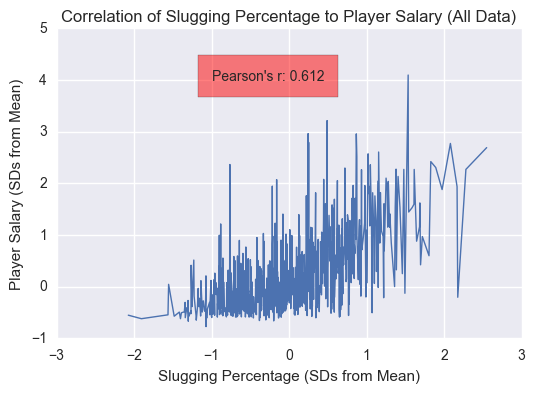

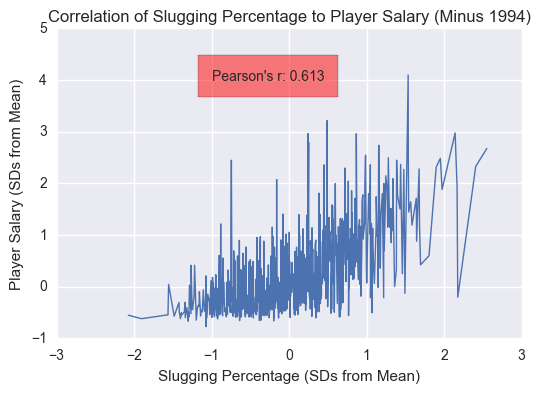

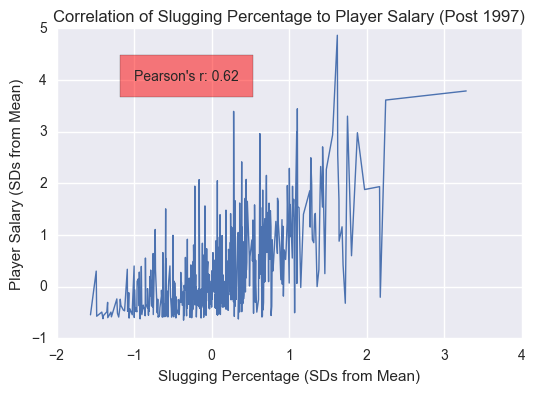

In [138]:
plot_data(average_data_all, 'SLG', 'Slugging Percentage', 5, 'All Data')
plot_data(average_data_sans_1994, 'SLG', 'Slugging Percentage', 5, 'Minus 1994')
plot_data(average_data_post_1997, 'SLG', 'Slugging Percentage', 5, 'Post 1997')

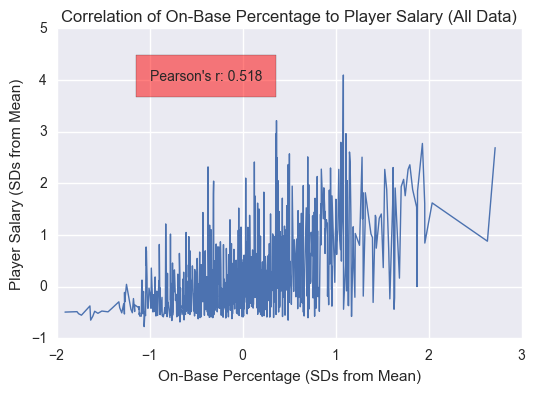

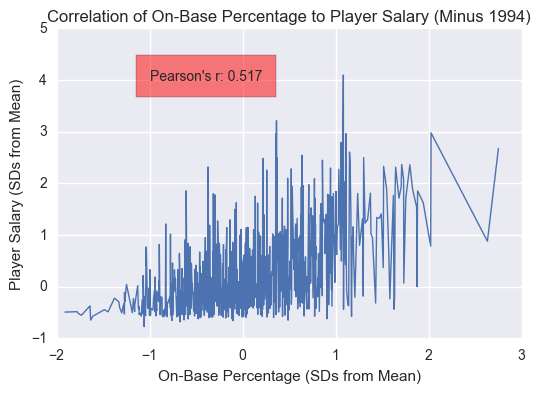

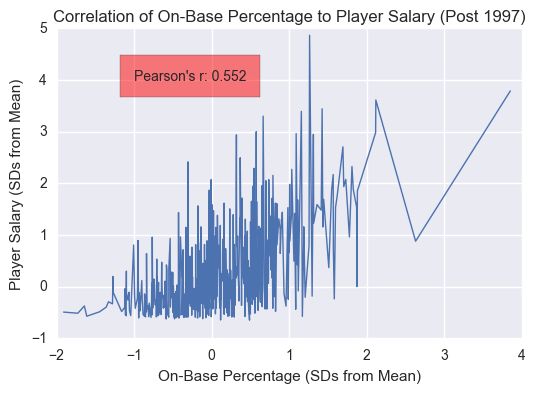

In [139]:
plot_data(average_data_all, 'OBP', 'On-Base Percentage', 5, 'All Data')
plot_data(average_data_sans_1994, 'OBP', 'On-Base Percentage', 5, 'Minus 1994')
plot_data(average_data_post_1997, 'OBP', 'On-Base Percentage', 5, 'Post 1997')

## Conclusion
In conclusion, it is clear that all four chosen batting statistics had a positive correlation on player salary, as would be expected, with none of them having Pearson's coefficient scores below 0.467, when looking at players whose careers lasted at least five years. It is also clear that slugging percentage (SLG) appears to be by far the most closely correlated with player salaries, with a Pearson's coefficient score between 0.612 and 0.62, depending on which data we're looking at.

It is also worth noting that there was very little difference between the Pearson's coefficient for all years and for all the years minus the strike-shortened season of 1994. I suppose this was to be expected, as one year out of over 30 shouldn't skew the data too much. However, there was quite a difference between the scores for all the data and for just the data after 1997. The correlation for HRAB, SLG, and OBP to salary all went up, even by as much as 8.8% in the case of the HRAB stat. There could be various reasons for this variance, which are unfortunately beyond the scope of this analysis, but it was worth noting, at least.

## Limitations of This Analysis
Of course, at this point it cannot be definitively stated that higher slugging percentage causes higher player salaries, only that there appears to be a strong positive correlation based on the data shown above. Also, there were several limitations for this study. For one, we had no player salary data before 1985, meaning our analysis could be skewed by more recent trends. We also had a lot of data for which not all batting statistics were present, and chose to remove those in order to perform our analysis, which could have skewed the data. Additionally, the results of this analysis have not undergone any rigorous statistical testing, so we can only state our conclusions tentatively.

## References
* [Pandas.DataFrame documentation](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.html)
* [Matplotlib documentation](http://matplotlib.org/)
* [MLB rules and regulations](http://mlb.mlb.com/mlb/official_info/about_mlb/rules_regulations.jsp)
* [Baseball Offensive Stats Formulae](http://www.csgnetwork.com/baseballoffensestatsformulae.html)
* [Sean Lahman's Baseball Database](http://www.seanlahman.com/baseball-archive/statistics/)
* [Python's range function explained (for frange code)](http://pythoncentral.io/pythons-range-function-explained/)